In [1]:
# Nash Cascade Neural Network
# A hydrologically intuitive deep learning network

# Set up a solution to a network of buckets where the number of buckets in each layer
# flows out to the buckets in the next layer
# The parameter on each bucket is the size and height of each spigot.

# Need a function that solves this individually at a single buckets
# Then a function that loops through and moves the water to the downstream buckets

In [2]:
import torch
import copy
import matplotlib.pyplot as plt
from ncnn import NashCascadeNeuralNetwork as ncnn
from ncnn import train_theta_values as train_ncnn
from ncn import NashCascadeNetwork as ncn
# Precipitation standard variable name used in the ncnn model interface
PRECIP_SVN = "atmosphere_water__liquid_equivalent_precipitation_rate"
DO_PLOT = True
N_TIMESTEPS = 180

In [3]:
network_precip_input_list = []
count = 0
for i in range(N_TIMESTEPS):

    ###########################################################################
    if count > 39:
        network_precip_input_list.append(3.0)
    else:
        network_precip_input_list.append(0.0)
    if count == 50:
        count = 0
    count+=1
    ###########################################################################
network_precip_tensor = torch.tensor(network_precip_input_list, requires_grad=True)
total_mass_precip_in = torch.sum(network_precip_tensor)

In [4]:
bucket_net = ncn(cfg_file="./config_0.json")
bucket_net.initialize()

Initial Mass in network at start: 600.0
tensor([0.8969, 0.3666], grad_fn=<CopySlices>)
tensor([5.3711], grad_fn=<CopySlices>)
tensor([0.8941, 0.3654], grad_fn=<CopySlices>)
tensor([5.3034], grad_fn=<CopySlices>)
tensor([0.8913, 0.3643], grad_fn=<CopySlices>)
tensor([5.2356], grad_fn=<CopySlices>)
tensor([0.8884, 0.3631], grad_fn=<CopySlices>)
tensor([5.1679], grad_fn=<CopySlices>)
tensor([0.8856, 0.3619], grad_fn=<CopySlices>)
tensor([5.1003], grad_fn=<CopySlices>)
tensor([0.8827, 0.3608], grad_fn=<CopySlices>)
tensor([5.0327], grad_fn=<CopySlices>)
tensor([0.8799, 0.3596], grad_fn=<CopySlices>)
tensor([4.9651], grad_fn=<CopySlices>)
tensor([0.8770, 0.3584], grad_fn=<CopySlices>)
tensor([4.8976], grad_fn=<CopySlices>)
tensor([0.8742, 0.3573], grad_fn=<CopySlices>)
tensor([4.8301], grad_fn=<CopySlices>)
tensor([0.8714, 0.3561], grad_fn=<CopySlices>)
tensor([4.7627], grad_fn=<CopySlices>)
tensor([0.8685, 0.3549], grad_fn=<CopySlices>)
tensor([4.6953], grad_fn=<CopySlices>)
tensor([0.8657

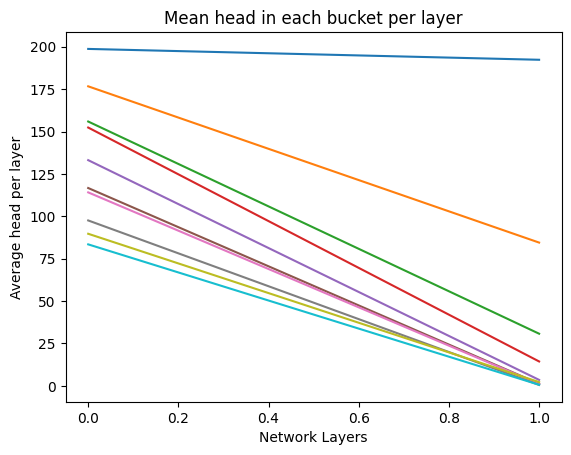

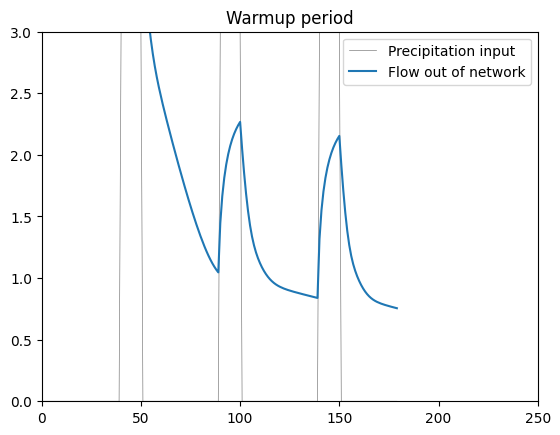

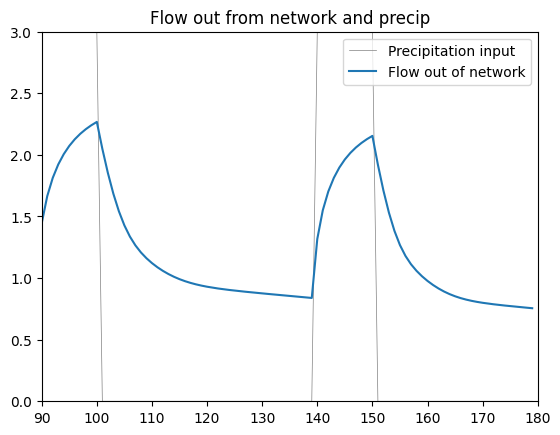

In [5]:
# Example 0
bucket_net = ncn(cfg_file="./config_0.json")
bucket_net.initialize()
bucket_net.summarize_network()
inital_mass_in_network = torch.sum(torch.tensor([tensor.item() for tensor in bucket_net.sum_H_per_layer]))
print(f"Initial Mass in network at start: {inital_mass_in_network:.1f}")
network_outflow_list_0 = []
for i in range(N_TIMESTEPS):

    ###########################################################################
    ###########################################################################
    bucket_net.set_value(PRECIP_SVN, torch.tensor(network_precip_input_list[i], requires_grad=True))
    bucket_net.update_network()
    network_outflow_list_0.append(bucket_net.network_outflow.item())
    bucket_net.summarize_network()
    ###########################################################################
    ###########################################################################

    if DO_PLOT:
        if i % int(N_TIMESTEPS/10) == 0:
            plt.plot([tensor.item() for tensor in bucket_net.mean_H_per_layer])

network_outflow_tensor_0 = torch.tensor(network_outflow_list_0, requires_grad=True)
bucket_net.report_out_mass_balance()
bucket_net.detach_ncn_from_graph()
bucket_net.theta.detach()

if DO_PLOT:
    plt.title("Mean head in each bucket per layer")
    plt.ylabel("Average head per layer")
    plt.xlabel("Network Layers")
    plt.show()
    plt.close()

if DO_PLOT:
    startplt = 0
    endplt = 250

    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list[startplt:endplt])).item()])
    plt.legend()
    plt.title("Warmup period")
    plt.show()
    plt.close()
    startplt = int(len(network_outflow_list_0)-(len(network_outflow_list_0)/2))
    endplt = int(len(network_outflow_list_0))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list[startplt:endplt])).item()])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

Initial Mass in network at start: 600.0
tensor([3.0356, 3.8122], grad_fn=<CopySlices>)
tensor([3.9485], grad_fn=<CopySlices>)
tensor([2.9830, 3.7460], grad_fn=<CopySlices>)
tensor([3.9465], grad_fn=<CopySlices>)
tensor([2.9304, 3.6798], grad_fn=<CopySlices>)
tensor([3.9439], grad_fn=<CopySlices>)
tensor([2.8777, 3.6136], grad_fn=<CopySlices>)
tensor([3.9407], grad_fn=<CopySlices>)
tensor([2.8251, 3.5473], grad_fn=<CopySlices>)
tensor([3.9369], grad_fn=<CopySlices>)
tensor([2.7724, 3.4811], grad_fn=<CopySlices>)
tensor([3.9324], grad_fn=<CopySlices>)
tensor([2.7198, 3.4148], grad_fn=<CopySlices>)
tensor([3.9274], grad_fn=<CopySlices>)
tensor([2.6671, 3.3486], grad_fn=<CopySlices>)
tensor([3.9217], grad_fn=<CopySlices>)
tensor([2.6144, 3.2823], grad_fn=<CopySlices>)
tensor([3.9155], grad_fn=<CopySlices>)
tensor([2.5617, 3.2160], grad_fn=<CopySlices>)
tensor([3.9086], grad_fn=<CopySlices>)
tensor([2.5090, 3.1497], grad_fn=<CopySlices>)
tensor([3.9011], grad_fn=<CopySlices>)
tensor([2.4563

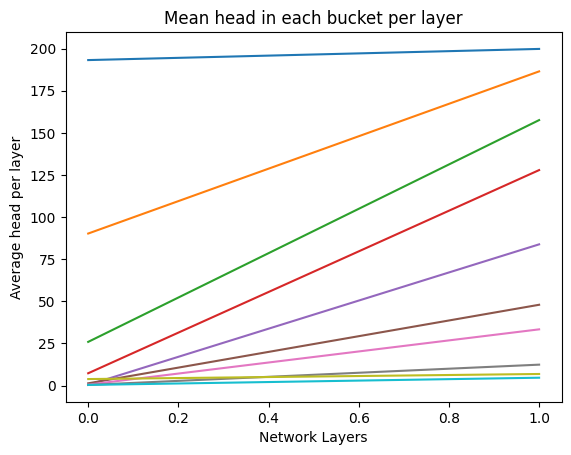

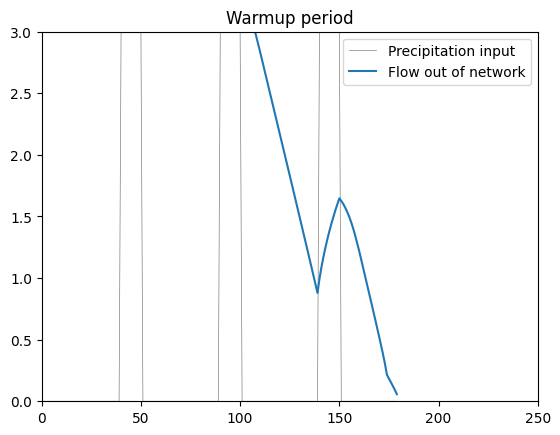

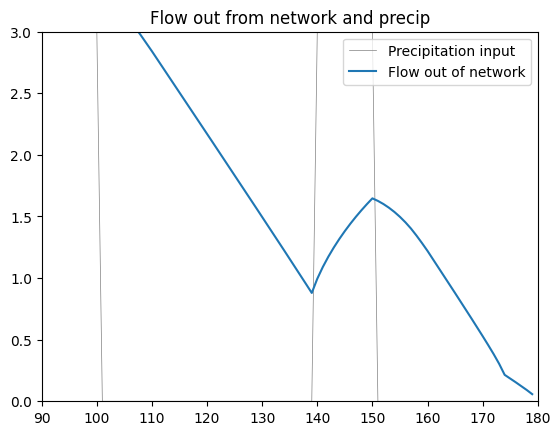

In [6]:
# Example 1
bucket_nn = ncnn(cfg_file="./config_1.json")
inital_mass_in_network = torch.sum(torch.stack(bucket_nn.ncn.sum_H_per_layer)).item()
print(f"Initial Mass in network at start: {inital_mass_in_network:.1f}")
network_outflow_list_1 = []
for i in range(N_TIMESTEPS):

    ###########################################################################
    ###########################################################################
    bucket_nn.ncn.set_value(PRECIP_SVN, torch.tensor(network_precip_input_list[i], requires_grad=True))
    bucket_nn.ncn.update_network()
    network_outflow_list_1.append(bucket_nn.ncn.network_outflow.item())
    bucket_nn.ncn.summarize_network()
    ###########################################################################
    ###########################################################################

    if DO_PLOT:
        if i % int(N_TIMESTEPS/10) == 0:
            plt.plot([tensor.item() for tensor in bucket_nn.ncn.mean_H_per_layer])

###########################################################################
network_outflow_tensor_1 = torch.tensor(network_outflow_list_1, requires_grad=True)
bucket_nn.ncn.report_out_mass_balance()

origional_bucket_theta = copy.deepcopy(bucket_nn.ncn.theta.detach())

if DO_PLOT:
    plt.title("Mean head in each bucket per layer")
    plt.ylabel("Average head per layer")
    plt.xlabel("Network Layers")
    plt.show()
    plt.close()

if DO_PLOT:
    startplt = 0
    endplt = 250

    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_1, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list)[startplt:endplt]).item()])
    plt.legend()
    plt.title("Warmup period")
    plt.show()
    plt.close()
    startplt = int(len(network_outflow_list_1)-(len(network_outflow_list_1)/2))
    endplt = int(len(network_outflow_list_1))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_1, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list)[startplt:endplt]).item()])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

In [7]:
DO_PLOT = True

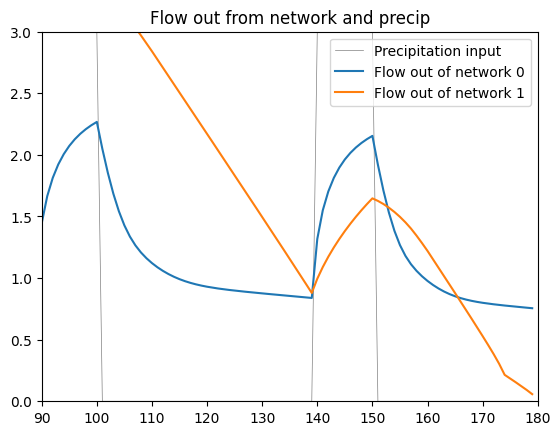

In [8]:
if DO_PLOT:
    # startplt = 0
    # endplt = 250

    # plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    # plt.plot(network_outflow_list_0, label="Flow out of network 0")
    # plt.plot(network_outflow_list_1, label="Flow out of network 1")
    # plt.xlim([startplt, endplt])
    # tensor_version = torch.tensor(network_precip_input_list)
    # max_val = torch.max(tensor_version[startplt:endplt]).item()
    # plt.ylim([0, max_val])
    # plt.legend()
    # plt.title("Warmup period")
    # plt.show()
    # plt.close()
    startplt = int(len(network_outflow_list_1)-(len(network_outflow_list_1)/2))
    endplt = int(len(network_outflow_list_1))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network 0")
    plt.plot(network_outflow_list_1, label="Flow out of network 1")
    plt.xlim([startplt, endplt])
    max_value = torch.max(network_precip_tensor[startplt:endplt]).item()
    plt.ylim([0, max_value])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

In [9]:
y_pred, loss = train_ncnn(bucket_nn, "./config_1.json", network_precip_tensor, network_outflow_tensor_0)

network_outflow_list_1 = list(y_pred.detach().numpy())

print(bucket_net.theta.grad)

tensor([3.0356, 3.8122], grad_fn=<CopySlices>)
tensor([3.9485], grad_fn=<CopySlices>)
tensor([2.9830, 3.7460], grad_fn=<CopySlices>)
tensor([3.9465], grad_fn=<CopySlices>)
tensor([2.9304, 3.6798], grad_fn=<CopySlices>)
tensor([3.9439], grad_fn=<CopySlices>)
tensor([2.8777, 3.6136], grad_fn=<CopySlices>)
tensor([3.9407], grad_fn=<CopySlices>)
tensor([2.8251, 3.5473], grad_fn=<CopySlices>)
tensor([3.9369], grad_fn=<CopySlices>)
tensor([2.7724, 3.4811], grad_fn=<CopySlices>)
tensor([3.9324], grad_fn=<CopySlices>)
tensor([2.7198, 3.4148], grad_fn=<CopySlices>)
tensor([3.9274], grad_fn=<CopySlices>)
tensor([2.6671, 3.3486], grad_fn=<CopySlices>)
tensor([3.9217], grad_fn=<CopySlices>)
tensor([2.6144, 3.2823], grad_fn=<CopySlices>)
tensor([3.9155], grad_fn=<CopySlices>)
tensor([2.5617, 3.2160], grad_fn=<CopySlices>)
tensor([3.9086], grad_fn=<CopySlices>)
tensor([2.5090, 3.1497], grad_fn=<CopySlices>)
tensor([3.9011], grad_fn=<CopySlices>)
tensor([2.4563, 3.0834], grad_fn=<CopySlices>)
tensor(

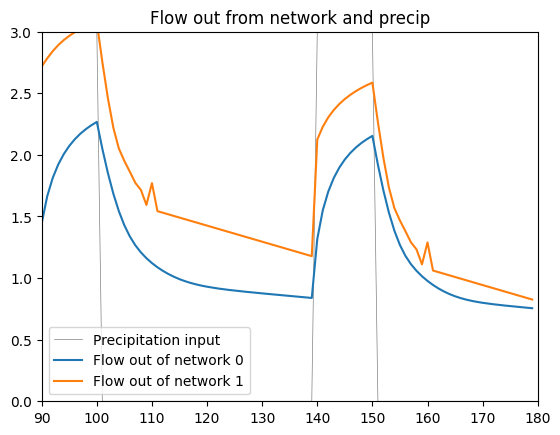

In [10]:
if DO_PLOT:

    # startplt = 0
    # endplt = 250

    # plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    # plt.plot(network_outflow_list_0, label="Flow out of network 0")
    # plt.plot(network_outflow_list_1, label="Flow out of network 1")
    # plt.xlim([startplt, endplt])
    # network_precip_tensor = torch.tensor(network_precip_input_list)
    # max_value = torch.max(network_precip_tensor[startplt:endplt]).item()
    # plt.ylim([0, max_value])
    # plt.legend()
    # plt.title("Warmup period")
    # plt.show()
    # plt.close()
    startplt = int(len(network_outflow_list_1)-(len(network_outflow_list_1)/2))
    endplt = int(len(network_outflow_list_1))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network 0")
    plt.plot(network_outflow_list_1, label="Flow out of network 1")
    plt.xlim([startplt, endplt])
    network_precip_tensor = torch.tensor(network_precip_input_list)
    max_value = torch.max(network_precip_tensor[startplt:endplt]).item()
    plt.ylim([0, max_value])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

In [11]:
bucket_net.network

{0: {'H': tensor([70.1596]),
  'S': tensor([[[0.2805, 0.2822],
           [0.8558, 0.1451]]]),
  's_q': tensor([[0.5334, 0.2173]])},
 1: {'H': tensor([0.0532, 0.8914]),
  'S': tensor([[[0.1313, 0.8018]],
  
          [[0.7767, 0.3535]]]),
  's_q': tensor([[0.5354],
          [0.2200]])}}

In [12]:
bucket_nn.ncn.network

{0: {'H': tensor([0.3999]),
  'S': tensor([[[0.7576, 0.2793],
           [0.4031, 0.7347]]]),
  's_q': tensor([[0., 0.]])},
 1: {'H': tensor([26.0124,  0.4698]),
  'S': tensor([[[0.5695, 0.4388]],
  
          [[0.6387, 0.5247]]]),
  's_q': tensor([[0.8258],
          [0.0000]])}}

In [13]:
bucket_net.theta

Parameter containing:
tensor([[[0.0508, 0.0405],
         [0.0000, 0.0000]],

        [[0.2229, 0.0000],
         [0.2428, 0.0000]]], requires_grad=True)

In [14]:
bucket_nn.ncn.theta

Parameter containing:
tensor([[[0.1738, 0.0832],
         [0.0000, 0.0000]],

        [[0.0829, 0.0000],
         [0.4303, 0.0000]]], requires_grad=True)

In [15]:
origional_bucket_theta

tensor([[[0.1738, 0.0832],
         [0.0000, 0.0000]],

        [[0.1213, 0.0000],
         [0.1192, 0.0000]]])

In [16]:
torch.sum(bucket_nn.ncn.theta - origional_bucket_theta)

tensor(0.2728, grad_fn=<SumBackward0>)

In [17]:
bucket_nn.ncn.theta - origional_bucket_theta

tensor([[[ 0.0000,  0.0000],
         [ 0.0000,  0.0000]],

        [[-0.0383,  0.0000],
         [ 0.3111,  0.0000]]], grad_fn=<SubBackward0>)

In [18]:
bucket_nn.ncn.theta.grad

tensor([[[0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00]],

        [[7.2867e-06, 0.0000e+00],
         [4.7553e-06, 0.0000e+00]]])